In [1]:
import glob
import json
import os
from typing import List

import cv2
import detectron2.data.transforms as T
import matplotlib.pyplot as plt
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    DatasetMapper,
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
from utils import (
    annotate_polygons,
    basic_augmentation,
    create_dataset_dicts,
    create_train_augmentations,
    move_train_test,
)


# Prepare Dataset

Splits dataset into train and test set with 80%/20% split

In [2]:
move_train_test("../data/bh")

Setup Dataset and Metadata

In [5]:
for dataset_type in ["train", "test"]:
    DatasetCatalog.register(
        f"hold_{dataset_type}",
        lambda d=dataset_type: create_dataset_dicts(f"../data/bh/{d}"),
    )
    MetadataCatalog.get(f"hold_{dataset_type}").thing_classes = ["hold", "volume"]
hold_metadata_train = MetadataCatalog.get("hold_train")
hold_metadata_test = MetadataCatalog.get("hold_test")

Load default config and make changes depending on experiment

In [6]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)

cfg.DATASETS.TRAIN = ("hold_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0006
cfg.SOLVER.MAX_ITER = 2_000
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 24_000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 12_000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 4_000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 2_000
cfg.SOLVER.STEPS = []
cfg.INPUT.MIN_SIZE_TRAIN = [640]
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.SEM_SEG_HEAD.IN_FEATURES = ["p2", "p3"]
cfg.MODEL.ROI_HEADS.IN_FEATURES = ["p2", "p3"]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64]]
experiment_name = "Basic_Augmented_P2P3_DoubleTopK_NMS_2KIT"
output_dir = "output"
cfg.OUTPUT_DIR = os.path.join(output_dir, experiment_name)

# Train Model

Setup `Trainer` class with custom augmentations

In [6]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(
            cfg, is_train=True, augmentations=create_train_augmentations(cfg)
        )
        return build_detection_train_loader(cfg, mapper=mapper)


# Persist experiment config
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(os.path.join(cfg.OUTPUT_DIR, "experiment_config.yml"), "w") as f:
    f.write(cfg.dump())

In [7]:
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/23 16:49:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (12, 256, 1, 1) in the checkpoint but (24, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible s

[03/23 16:49:38 d2.engine.train_loop]: Starting training from iteration 0


/home/philipp/anaconda3/envs/cv_final/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/23 16:50:00 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fdcb75c3e50> to CPU due to CUDA OOM
[03/23 16:50:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fdcb75c3e50> to CPU due to CUDA OOM
[03/23 16:50:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fdcb75c3e50> to CPU due to CUDA OOM
[03/23 16:50:18 d2.utils.events]:  eta: 0:52:03  iter: 19  total_loss: 3.688  loss_cls: 1.08  loss_box_reg: 0.1066  loss_mask: 0.6934  loss_rpn_cls: 0.7203  loss_rpn_loc: 1.081  time: 1.9535  last_time: 1.7077  data_time: 0.0517  last_data_time: 0.0037   lr: 1.1989e-05  max_mem: 4346M
[03/23 16:50:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fdcb75c3e50> to CPU due to CUDA OOM
[03/23 16:50:50 d2.utils.events]:  eta: 0:50:25  iter: 39  total_loss: 3.297  loss_cls: 0.6426  loss_box_reg: 0.09706  loss_mask: 0.6755  loss_rpn_cls: 0.7064  loss_rpn_loc: 1.166  time: 1.7556  last_ti

# Test Model

In [27]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # confidence threshold for testing
cfg.DETECTIONS_PER_IMAGE = 300
cfg.DATASETS.TEST = ("hold_test",)
predictor = DefaultPredictor(cfg)

In [8]:
for dataset_type in ["bh-phone", "sm"]:
    DatasetCatalog.register(
        f"hold_{dataset_type}",
        lambda d=dataset_type: create_dataset_dicts(f"../data/{d}"),
    )
    MetadataCatalog.get(f"hold_{dataset_type}").thing_classes = ["hold", "volume"]

Visualize Results on two test images

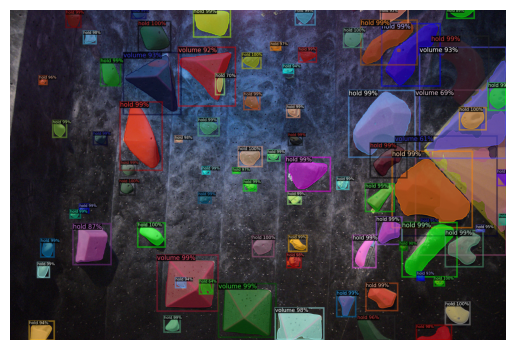

In [32]:
for i, file_name in enumerate(["../data/sm/108.jpg", "../data/bh/test/_DSC9396.jpg"]):
    im = cv2.imread(file_name)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=hold_metadata_test,
        scale=0.5,
    )
    out_predictions = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    fname = file_name.split("/")[-1].split(".")[0]
    fig, ax = plt.subplots()
    ax.axis("off")
    ax.imshow(out_predictions.get_image())
    fig.savefig(f"{fname}-labeled.jpg", bbox_inches="tight", dpi=300)

Calculate COCO Metrics on Boulderhaus test set

In [9]:
evaluator = COCOEvaluator(
    "hold_test", output_dir="./output", max_dets_per_image=cfg.DETECTIONS_PER_IMAGE
)
test_loader = build_detection_test_loader(cfg, "hold_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

[03/23 17:56:28 d2.evaluation.coco_evaluation]: Trying to convert 'hold_test' to COCO format ...
WARNING [03/23 17:56:28 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/hold_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[03/23 17:56:30 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    hold    | 194          |   volume   | 16           |
|            |              |            |              |
|   total    | 210          |            |              |
[03/23 17:56:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/23 17:56:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/23 17:56:30 d2.data.comm

## Test all models on all datasets

In [7]:
for fpath in glob.glob("output/Basic*/"):
    cfg = get_cfg()
    cfg.merge_from_file(os.path.join(fpath, "experiment_config.yml"))
    cfg.MODEL.WEIGHTS = os.path.join(fpath, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # confidence threshold for testing
    cfg.DETECTIONS_PER_IMAGE = 300
    cfg.DATASETS.TEST = ("hold_test", "hold_sm", "hold_bh-phone")
    predictor = DefaultPredictor(cfg)

    results = {}
    for dataset in cfg.DATASETS.TEST:
        evaluator = COCOEvaluator(
            dataset, output_dir="./output", max_dets_per_image=cfg.DETECTIONS_PER_IMAGE
        )
        test_loader = build_detection_test_loader(cfg, dataset)
        result = inference_on_dataset(predictor.model, test_loader, evaluator)
        results[dataset] = result

    # Dump results in model dir
    with open(os.path.join(fpath, "test_results.json"), "w") as f:
        json.dump(results, f)
    del predictor.model
    del predictor

/home/philipp/anaconda3/envs/cv_final/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.782
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=30

Using previously cached COCO format annotations at './output/hold_sm_coco_format.json'. You need to clear the cache file if your dataset has been modified.


DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.623
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=300 ] = 0.745
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=300 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=300 ] = 0.694
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=300 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=300 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

# Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

# Prelabeling

Use trained model to create bounding boxes and segmentations masks for new unlabeled images and store it in `annotation.json`.
The regions in these images have `label_type=prelabeled` and can then be fixed by hand in the VGG annotation tool.

In [76]:
annotate_polygons(predictor, "../data/bh")

100%|██████████| 1061/1061 [34:30<00:00,  1.95s/it]


# Visualize Data Augmentation

In [7]:
mapper = DatasetMapper(
    cfg, is_train=True, augmentations=create_train_augmentations(cfg)
)
loader = build_detection_train_loader(cfg, mapper=mapper)

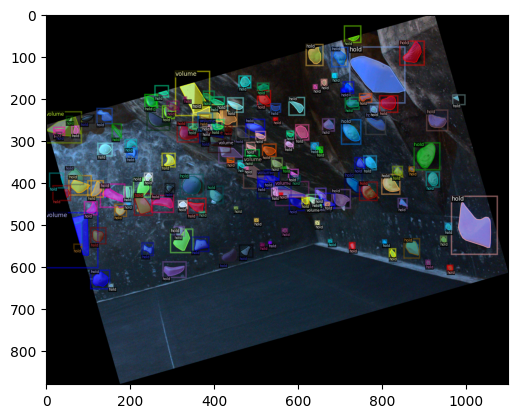

In [8]:
from detectron2.data import detection_utils as utils

for batch in loader:
    for image in batch:
        # torch (C,H,W) to (H,W,C)
        img = image["image"].permute(1, 2, 0).cpu().detach().numpy()
        img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

        visualizer = Visualizer(img, metadata=hold_metadata_test, scale=1)
        target_fields = image["instances"].get_fields()
        labels = [
            hold_metadata_test.thing_classes[i] for i in target_fields["gt_classes"]
        ]
        vis = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
        )
        fig, ax = plt.subplots()
        ax.imshow(vis.get_image()[:, :, ::-1])
        break
    break